<p></p>

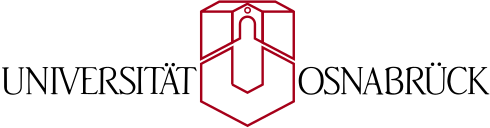
# <center>Einführung in die Künstliche Intelligenz</center> <a class="tocSkip">
### <center>Wintersemester 2020/21</center> <a class="tocSkip">
<center>Prof. Dr. Joachim Hertzberg, Felix Igelbrink, Alexander Mock</center>

# Übungsblatt 1: Suchverfahren

## Aufgabe: Suchverfahren
### Teilaufgaben


1. Benennen und erläutern Sie die vier Bewertungskriterien für Suchverfahren. (2 Punkte)

YOUR ANSWER HERE


2. Geben Sie Zeit- und Speicherkomplexität der iterativen Tiefensuche an. (1 Punkt)

YOUR ANSWER HERE

3. Bei der bidirektionalen Breitensuche wird ein zusätzlicher Suchbaum, ausgehend vom Zielzustand,
durchsucht, bis sich beide Suchbäume treffen. Erläutern Sie die dafür notwendigen Voraussetzungen
und geben Sie Zeit- und Speicherkomplexität an. Ist ein solcher Ansatz generell sinnvoll?  (2 Punkte)

YOUR ANSWER HERE

4. Warum ist eine bidirektionale Tiefensuche allgemein keine gute Idee? (1 Punkt)

YOUR ANSWER HERE

## Aufgabe: Flussüberquerung

Ein Bauer kommt mit Ziege, Wolf und Kohl zu einem Fluss, den
er überqueren möchte. Die beiden Ufer des Flusses seien mit
Ost und West bezeichnet. Der Bauer befindet sich mit Ziege,
Wolf und Kohl am Ostufer des Flusses. Es gibt ein Boot, aber es
hat nur Platz für zwei, und der Bauer ist der Einzige, der rudern
kann. Wenn die Ziege und der Kohl unbeaufsichtigt zusammen
sind, dann frisst die Ziege den Kohl. Wenn Wolf und Ziege ohne
den Bauer zusammen sind, wird die Ziege gefressen.
Wie kann der Bauer durch mehrfaches Überqueren des Flusses
mit Wolf, Ziege und Kohl über den Fluss, also ans Westufer,
kommen?

||
|:--:| 
| https://xkcd.com/1134/ |

### Teilaufgaben
1. Formulieren Sie dieses Rätsel als Suchproblem, d.h., geben Sie eine Repräsentation aller Zustände an. Was sind der Startzustand, der Endzustand und die Operatoren? (3 Punkte)



YOUR ANSWER HERE

2. Lösen Sie das Suchproblem mit einer Methode Ihrer Wahl. Zeichnen Sie den Suchbaum und beschreiben Sie die Lösung. (3 Punkte)



YOUR ANSWER HERE

## Aufgabe: Uninformierte Suche im Labyrinth

In dieser Aufgabe werden Sie die in der Vorlesung behandelten uninformierten Suchverfahren zur Lösung
von Labyrinthen einsetzen. Zur Generierung und Repräsentation eines Labyrinthes steht Ihnen im unten gegebenen Code die Klasse ```Maze```zur Verfügung. Diese erzeugt ein Labyrinth beliebiger Größe und bietet die Basisfunktionalität zum Aufbau des Suchbaumes. Zusätzlich sind einige Beispiele gegeben. Die entsprechenden Dateien können Sie mit der Funktion ```load_from_file``` in der ```Maze```-Klasse
laden.

Zur Ausführung benötigen Sie die zusätzlichen Pakete `matplotlib` und `numba` (optional), welche Sie mit
```bash
    conda install matplotlib numba
```
installieren können.


### Programmiervorlage

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import randint
import enum
# Try to import the numba just-in-time compiler
# This is optional and will not result in an error but will speed up the maze generation significantly!
try:
    from numba import njit
except ImportError:
    # use a dummy wrapper instead
    # this will be significantly slower
    def njit(*args, **kwargs):
        def __wrapped__(function):
            return function
        return __wrapped__   

class MazeTiles(enum.IntEnum):
    EMPTY = 0  # value of an empty tile
    WALL = 5   # value of a wall tile
    START = 1  # value of the start tile. This is only used when writing the maze to an ASCII representation.
    END = 2    # value of the goal tile. This is only used when writing the maze to an ASCII representation.
    

class Maze(object):
    """
    Class representing a Maze. By default it is randomly generated.
    """
    MAZE_DTYPE = np.int8  # data type of the maze representation
       
    # color values for the plot
    START_COLOR = 'blue'
    END_COLOR = 'red'


    def __init__(self, shape, complexity=0.75, density=0.50, seed=None, generate=True):
        """
        Initialize a maze with the given shape.
        Optionally, a maze is generated randomly using the randomized prim's algorithm
        (https://en.wikipedia.org/wiki/Maze_generation_algorithm).
        :param shape: tuple(x,y)
            The shape of the maze to create.
            Even x and y values will be increased by one so the resulting shape is always odd.
        :param complexity: float
            The complexity parameter when randomly generated (between 0.0 and 1.0).
        :param density: float
            The density of the randomly generated maze (between 0.0 and 1.0). Low values will
            result in more empty space between the walls of the maze.
        :param seed: int
            Seed to use for the random generation. By default it is initialized with the system entropy
        :param generate: bool
            Generate a random maze.
        """

        # Only odd shapes allowed
        self.shape = ((shape[0] // 2) * 2 + 1, (shape[1] // 2) * 2 + 1)
        self.board = np.zeros(self.shape, dtype=self.MAZE_DTYPE)
        # Fill borders
        self.board[0, :] = self.board[-1, :] = self.board[:, 0] = self.board[:, -1] = MazeTiles.WALL
        self.start = (1,1)
        self.end = (self.shape[0]-2, self.shape[1]-2)
        if generate:
            self._create(self.shape, complexity, density, seed)

    def to_ascii(self):
        """
        Convert the maze into an ascii representation that can be printed on the command line or stored in a file.
        :return: str
            ASCII representation of the maze.
        """
        rep = ''

        mapping = {MazeTiles.WALL: 'X',
                   MazeTiles.EMPTY: ' ',
                   MazeTiles.START: 'S',
                   MazeTiles.END: 'G'}
        board_copy = self.board.copy()
        board_copy[self.start] = MazeTiles.START
        board_copy[self.end] = MazeTiles.END
        for i in range(self.nrows):
            for j in range(self.ncolumns):
                try:
                    rep += mapping[board_copy[i, j]]
                except KeyError:
                    rep += ' '
            rep += '\n'
        return rep

    def plot(self, fig=None):
        """
        Plot the maze. This requires the matplotlib library.
        :return: matplotlib.Figure
            The figure of the plot. By default this can be ignored safely
        """
        import matplotlib.pyplot as plt
        if fig is None:
            fig = plt.figure(figsize=(10, 5))
        p = plt.imshow(self.board, cmap=plt.cm.binary, interpolation='nearest', zorder=-1)
        plt.scatter(self.start[1], self.start[0], c=self.START_COLOR, zorder=5)
        plt.scatter(self.end[1], self.end[0], c=self.END_COLOR, zorder=5)
        plt.gca().set_xticks(np.arange(-.5, self.shape[1], 1), minor=True)
        plt.gca().set_xticks(np.arange(self.shape[1], 5))
        plt.gca().set_yticks(np.arange(-.5, self.shape[0]+0.5, 1), minor=True)
        plt.gca().set_yticks(np.arange(self.shape[0], 5))
        plt.grid(which='minor')
        return fig

    def write_to_file(self, filename):
        """
        Write the maze into the given file in ASCII representation.
        :param filename: str
            The file to write
        """
        f = open(filename, 'w')
        f.write(self.to_ascii())
        f.close()

    @property
    def nrows(self):
        """
        Property to return the number of rows of the maze.
        :return: int
            number of rows.
        """
        return self.shape[0]

    @property
    def ncolumns(self):
        """
        Property to return the number of columns of the maze.
        :return: int
            number of columns.
        """
        return self.shape[1]

    def is_wall(self, x, y):
        """
        Return True if the given coordinate is a wall tile
        :param x: int
            the x coordinate
        :param y: int
            the y coordinate
        :return: bool
            True if a wall tile, False otherwise
        """
        return self.board[x, y] == MazeTiles.WALL

    def is_empty(self, x, y):
        """
        Return True if the given coordinate is an empty tile
        :param x: int
            the x coordinate
        :param y: int
            the y coordinate
        :return: bool
            True if a empty tile, False otherwise
        """
        return not self.board[x, y] == MazeTiles.EMPTY

    def _get_dead_ends(self):
        """
        Internal function. DO NOT USE
        """
        from scipy.signal import convolve2d
        board = self.board
        kernel = np.ones((3,3), dtype=self.MAZE_DTYPE)
        kernel[1,1] = 0

        indices = np.where(np.logical_and(board == 0, convolve2d(board, kernel, fillvalue=1, mode='same') == 7))
        return indices

    def set_start_end_random(self):
        """
        Set the start and end of the maze to random locations.
        Both coordinates will always be placed in dead ends of the maze.
        :return: tuple(start, end)
            The start and end location
        """
        dead_ends = self._get_dead_ends()
        indices = np.arange(0, dead_ends[0].shape[0])
        indices = np.random.choice(indices, 2)
        self.start = (dead_ends[0][indices[0]], dead_ends[1][indices[0]])
        self.end = (dead_ends[0][indices[1]], dead_ends[1][indices[1]])

        return self.start, self.end

    def set_start_end(self, start, end):
        """
        Set the start and end of the maze to specifiy values.
        Note, that this does not take the existing walls into account.
        :param start: tuple(x,y)
            The start coordinate
        :param end: tuple(x,y)
            The end coordinate
        """
        self.start = tuple(start)
        self.end = tuple(end)

    def get_neighbors(self, coord, visited=set()):
        """
        Get all neighbors of a given coordinate. The order will be always left, right, up, down.
        :param coord: tuple(x,y)
            The coordinate as tuple of x and y
        :param visited: set 
            Optional visited set to exclude neighbors that have already been visited
        :return: list(tuple)
            List of all neighbors as (x,y) tuples
        """
        neighbors = [(coord[0] - 1, coord[1]), (coord[0] + 1, coord[1]), (coord[0], coord[1] - 1),
                    (coord[0], coord[1] + 1)]
        return [c for c in neighbors if self.board[c[0], c[1]] != MazeTiles.WALL and c not in visited]

    def get_neighbors_iter(self, coord, visited=set()):
        c = (coord[0], coord[1] + 1)
        if self.board[c[0], c[1]] != MazeTiles.WALL and c not in visited:
            yield c
        c = (coord[0], coord[1] - 1)
        if self.board[c[0], c[1]] != MazeTiles.WALL and c not in visited:
            yield c
        c = (coord[0] + 1, coord[1])
        if self.board[c[0], c[1]] != MazeTiles.WALL and c not in visited:
            yield c
        c = (coord[0] - 1, coord[1])
        if self.board[c[0], c[1]] != MazeTiles.WALL and c not in visited:
            yield c

    @classmethod
    def load_from_file(cls, filename):
        """
        Load a new maze from a file.
        :param filename: str
            The file to load
        :return: Maze
            New maze loaded from file
        """
        with open(filename, 'r') as f:
            content = f.readlines()

        # remove whitespace characters like `\n` at the end of each line
        content = [x.strip() for x in content]

        inverse_mapping = {'X': MazeTiles.WALL,
                           ' ': MazeTiles.EMPTY}
        xss = []
        start = None
        end = None
        for i, line in enumerate(content):
            xs = []
            for j, c in enumerate(line):
                try:
                    xs.append(inverse_mapping[c])
                except KeyError as e:
                    xs.append(MazeTiles.EMPTY)
                    if c == 'S':
                        start = (i, j)
                    elif c == 'G':
                        end = (i, j)
                    else:
                        raise e

            xss.append(xs)

        if (start is None) ^ (end is None):
            raise ArithmeticError("Either start or end not defined")

        maze = Maze((len(xss), len(xss[0])), generate=False)
        if start is not None:
            maze.set_start_end(start, end)
        for xs in xss:
            assert len(xs) == maze.ncolumns

        maze.board = np.asarray(xss)
        return maze

    def _create(self, shape, complexity=0.75, density=0.50, seed=None):
        """
        Build a maze using given complexity and density. INTERNAL FUNCTION, DO NOT USE!
        For parameters see the constructor.
        """
        if seed is not None:
            np.random.seed(seed)

        # Only odd shapes
        shape = ((shape[0] // 2) * 2 + 1, (shape[1] // 2) * 2 + 1)

        # Adjust complexity and density relatively to maze size
        n_complexity = int(complexity * (shape[0] + shape[1]))
        n_density = int(density * (shape[0] * shape[1]))

        # reinit actual maze
        self.board = np.zeros(shape, dtype=self.MAZE_DTYPE)
        Z = self.board

        # Fill borders
        Z[0, :] = Z[-1, :] = Z[:, 0] = Z[:, -1] = MazeTiles.WALL

        # Islands starting point with a bias in favor of border
        P = np.random.normal(0, 0.5, (n_density, 2))
        P = 0.5 - np.maximum(-0.5, np.minimum(P, +0.5))
        P = (P * [shape[1], shape[0]]).astype(int)
        P = 2 * (P // 2)

        WALL = MazeTiles.WALL
        EMPTY = MazeTiles.EMPTY

        @njit()
        def create_islands(Z, P,  n_density, n_complexity):
            if seed is not None:

                np.random.seed(seed)
            # Create islands
            for i in range(n_density):

                # Test for early stop: if all starting point are busy, this means we
                # won't be able to connect any island, so we stop.
                T = Z[2:-2:2, 2:-2:2]
                if T.sum() == T.size:
                    break

                x, y = P[i]
                Z[y, x] = WALL
                for j in range(n_complexity):
                    neighbours = []
                    if x > 1:
                        neighbours.append([(y, x - 1), (y, x - 2)])
                    if x < shape[1] - 2:
                        neighbours.append([(y, x + 1), (y, x + 2)])
                    if y > 1:
                        neighbours.append([(y - 1, x), (y - 2, x)])
                    if y < shape[0] - 2:
                        neighbours.append([(y + 1, x), (y + 2, x)])
                    if len(neighbours):
                        choice = np.random.randint(len(neighbours))
                        next_1, next_2 = neighbours[choice]
                        if Z[next_2] == EMPTY:
                            Z[next_1] = Z[next_2] = WALL
                            y, x = next_2
                    else:
                        break

        create_islands(Z, P, n_density, n_complexity)
        return Z

#### Laden gespeicherter Labyrinthe

In [ ]:
examples = ["examples/labyrinth_20x20.maze", 
            "examples/labyrinth_50x50.maze", 
            "examples/labyrinth_100x100.maze", 
            "examples/labyrinth_200x200.maze"]
m = Maze.load_from_file(examples[0])
fig = m.plot()
fig.canvas.set_window_title(examples[0])
plt.show()

#### Generierung neue Labyrinthe

In [ ]:
m = Maze((250,250))
fig = m.plot()
plt.show()

#### Naive "Suche"

In [ ]:
def naive_search(maze, start, goal):
    from random import choice
    pos = start
    path = [pos]
    while pos != goal:
        # always take a random action
        neighbors = maze.get_neighbors(pos)
        pos = choice(neighbors)
        path.append(pos)
    path = np.array(path).T
    return path, ()

m = Maze.load_from_file("examples/labyrinth_20x20.maze")
path, stats = naive_search(m, m.start, m.end)
print("naive search length", len(path[0]))
fig = m.plot()
fig.gca().scatter(path[1], path[0], c='lightcoral', zorder=2, alpha=0.8)
plt.show()

### Teilaufgaben
1. Implementieren einen Algorithmus zur Suche eines Pfades vom Start- zum Zielpunkt mittels Breitensuche wie in der Vorlesung dargestellt. Ermitteln Sie für die gegebenen Beispiele:
    - Laufzeit
    - Anzahl der expandierten Knoten
    - Maximale Tiefe des Suchbaumes
    - Maximale Größe der Suchfront
    - Länge der gefundenen Lösung

 Stellen Sie den ermittelten Pfad sowie alle vom Algorithmus besuchten Felder des Labyrinths grafisch
dar. (7 Punkte)

In [ ]:
#TODO: INSERT YOUR CODE HERE


2. Implementieren Sie analog den Algorithmus der Tiefensuche. Ermitteln Sie auch hier die Werte aus dem vorherigen Teil und vergleichen Sie die Ergebnisse mit denen der Breitensuche. Was fällt Ihnen auf? (6 Punkte)

In [ ]:
#TODO: INSERT YOUR CODE HERE


3. Erweitern Sie die Tiefensuche zu einer iterativ beschränkten Tiefensuche. Vergleichen Sie erneut die
ermittelten Werte. (5 Punkte)

In [ ]:
#TODO: INSERT YOUR CODE HERE


In [ ]:
#TODO: INSERT YOUR CODE HERE
